# Import Required Libraries
---

In [7]:
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
import copy
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_rows', 90)


# Data Cleaning
---
Columns that are ignored and its reasons are listed below
- These are just descriptive columns: 'ID', 'Name', 'Photo', 'Nationality' ,'Flag', 'Club', 'Club Logo', 'Real Face', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until'. Hence they are ignored. These do not add any value while clustering.
- ‘Body Type’ is a redundant column. It can be derived from [ ‘Height’ and ‘Weight’]. Also categorical value count is high for this column. 
- Numeric values have been extracted and converted to float for these columns - [ ‘Value', 'Wage', 'Height', 'Weight', 'Release Clause' ]
- Following columns have been encoded as categorical codes - ['Work Rate', 'Position’, 'Preferred Foot' ]
- The dataset has 18207 samples. Of these, 3464 rows have missing values in them. Hence we drop them. 

The final dataset has 14743 samples and 76 features and is of shape (14743, 76) (inclusive of ‘Name’ column) with float values.



In [8]:
data_path = 'https://raw.githubusercontent.com/nee2shaji/IIITH_Sem3/master/football_data.csv'
fb_data = pd.read_csv(data_path, encoding = 'unicode_escape')


cols_of_importance = ['Name', 'Age', 'Overall',
       'Potential', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Position',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']

data = fb_data[cols_of_importance]   

print("Size of Data: "+ str(data.shape))

# print("Number of missing values:")
# print(fb_data.isna().sum())
print("There are about 3464 rows with missing values. Hence we drop them\n");
fb_data = fb_data[data.isna().any(axis=1) == False]
data = data[data.isna().any(axis=1) == False]

print("Size of Data after dropping missing values: "+ str(data.shape))

print("Unique Values in Preferred Foot: " + str(len(set(data['Preferred Foot']))))
print("Unique Values in Work Rate: " + str(len(set(data['Work Rate']))))
print("Unique Values in Position: " + str(len(set(data['Position']))))
print("Unique Values in Club: " + str(len(set(fb_data['Club']))))
print("Unique Values in Nationality: " + str(len(set(fb_data['Nationality']))))

names = data.Name.tolist()



Size of Data: (18207, 76)
There are about 3464 rows with missing values. Hence we drop them

Size of Data after dropping missing values: (14743, 76)
Unique Values in Preferred Foot: 2
Unique Values in Work Rate: 9
Unique Values in Position: 26
Unique Values in Club: 651
Unique Values in Nationality: 160


In [9]:
data.drop(['Name'], axis=1, inplace=True)

data['Value'] = data['Value'].str.extract(r'([0-9.]+)').astype('float')
data['Wage'] = data['Wage'].str.extract(r'([0-9.]+)').astype('float')
data['Preferred Foot'] = np.where(data['Preferred Foot']=='Left', 0, 1)
data['Height'] = [s.split('\'') for s in data['Height'].astype('str') ]
data['Height'] = [float(value[0])*12 + float(value[1]) for value in data['Height']]
data['Weight'] = data['Weight'].str.extract(r'([0-9.]+)').astype('float')
data['Release Clause'] = data['Release Clause'].str.extract(r'([0-9.]+)').astype('float')

data['Work Rate'] = data['Work Rate'].astype('category').cat.codes
data['Position'] = data['Position'].astype('category').cat.codes

position_columns = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
for col in position_columns:
  data[col] = data[col].str.extract(r'(^\d+)').astype('float')

# print("Check count of null values :")
# print(data[data.isna().any(axis=1)].count())
# print(data.dtypes)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

data.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,94,110.5,565.0,2202,0,5.0,4.0,4.0,8,20,67.0,159.0,88.0,88.0,88.0,92.0,93.0,93.0,93.0,92.0,93.0,93.0,93.0,91.0,84.0,84.0,84.0,91.0,64.0,61.0,61.0,61.0,64.0,59.0,47.0,47.0,47.0,59.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5
1,33,94,94,77.0,405.0,2228,1,5.0,4.0,5.0,1,25,74.0,183.0,91.0,91.0,91.0,89.0,90.0,90.0,90.0,89.0,88.0,88.0,88.0,88.0,81.0,81.0,81.0,88.0,65.0,61.0,61.0,61.0,65.0,61.0,53.0,53.0,53.0,61.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1
2,26,92,93,118.5,290.0,2143,1,5.0,5.0,5.0,2,13,69.0,150.0,84.0,84.0,84.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,88.0,81.0,81.0,81.0,88.0,65.0,60.0,60.0,60.0,65.0,60.0,47.0,47.0,47.0,60.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1
4,27,91,92,102.0,355.0,2281,1,4.0,5.0,4.0,0,18,71.0,154.0,82.0,82.0,82.0,87.0,87.0,87.0,87.0,87.0,88.0,88.0,88.0,88.0,87.0,87.0,87.0,88.0,77.0,77.0,77.0,77.0,77.0,73.0,66.0,66.0,66.0,73.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4
5,27,91,91,93.0,340.0,2142,1,4.0,4.0,4.0,2,10,68.0,163.0,83.0,83.0,83.0,89.0,88.0,88.0,88.0,89.0,89.0,89.0,89.0,89.0,82.0,82.0,82.0,89.0,66.0,63.0,63.0,63.0,66.0,60.0,49.0,49.0,49.0,60.0,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172.1


# Q1) Data visualisation

- Plot histograms of count of players on the basis of some attributes like height
- Distribution of players in different clubs/country on the basis of some attribute
- Features of players according to their position
- Can you use visualisation techniques to find outliers?  Like Ronaldo and Messi.

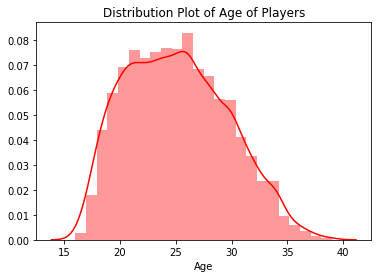

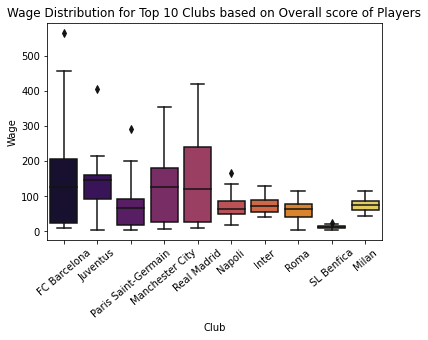

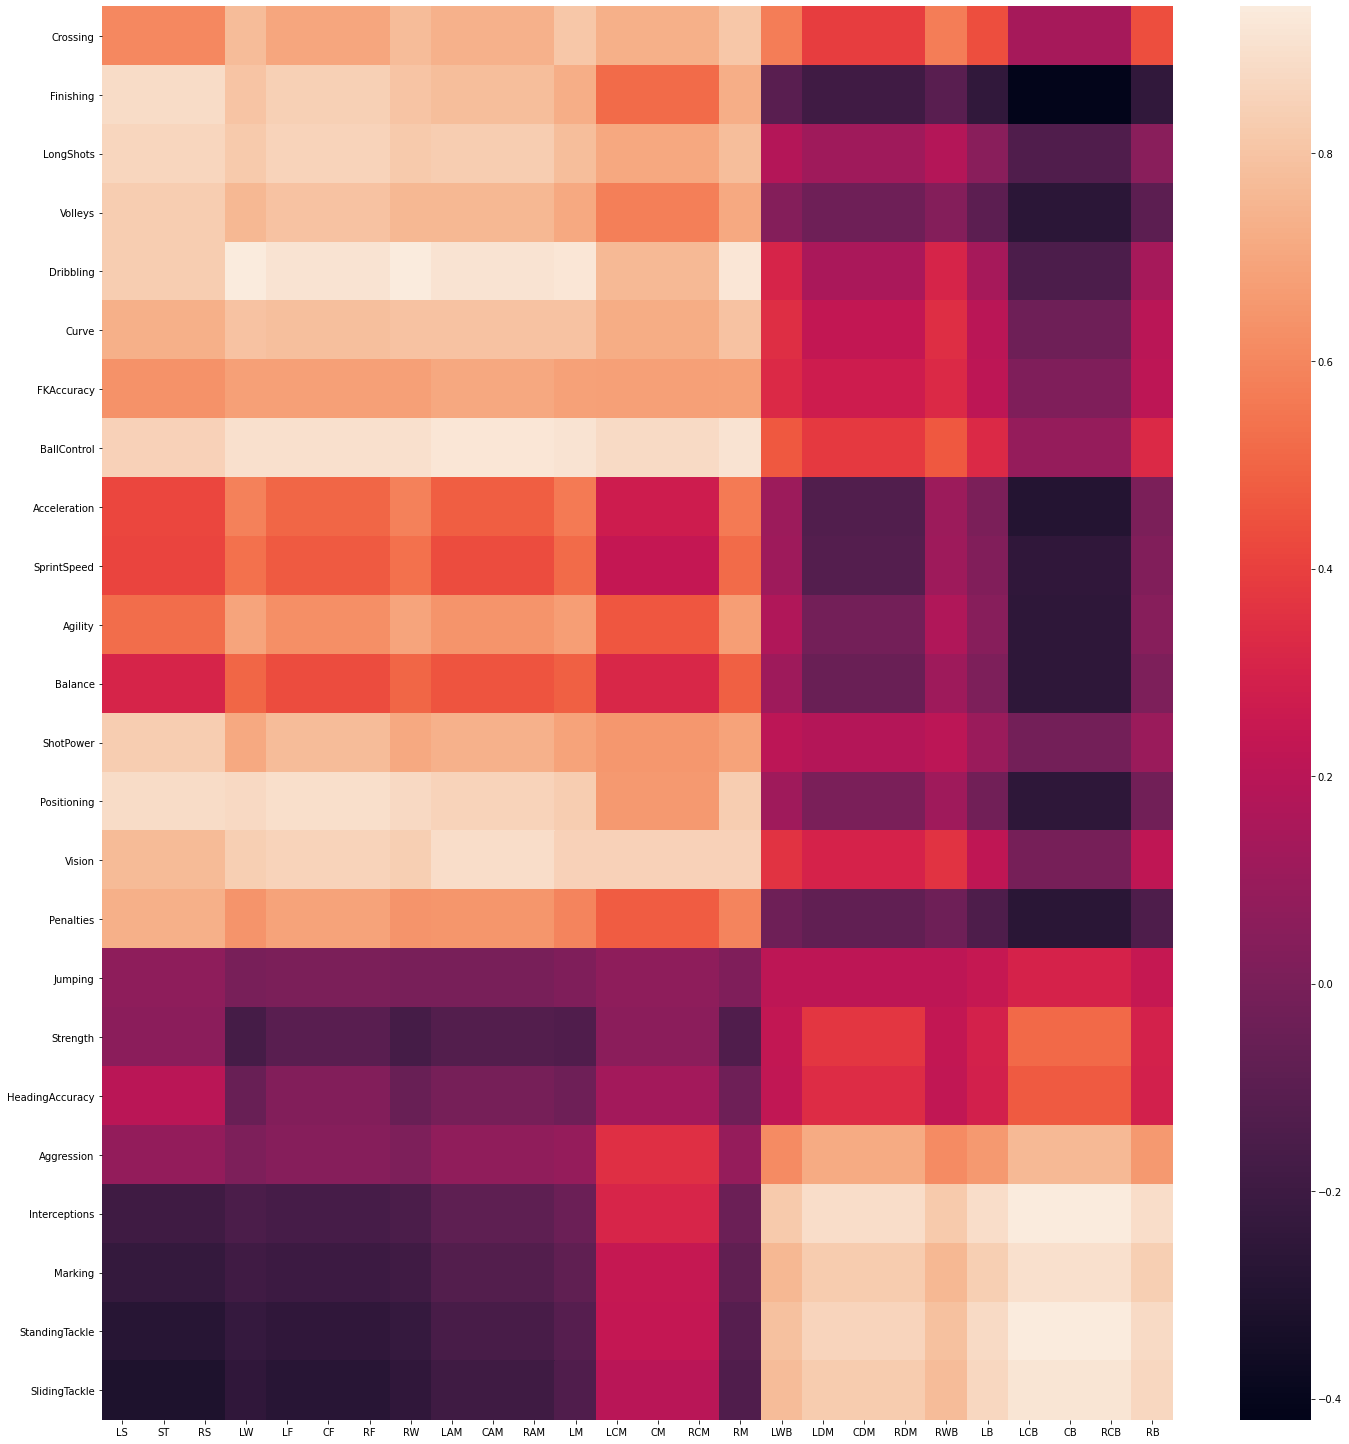

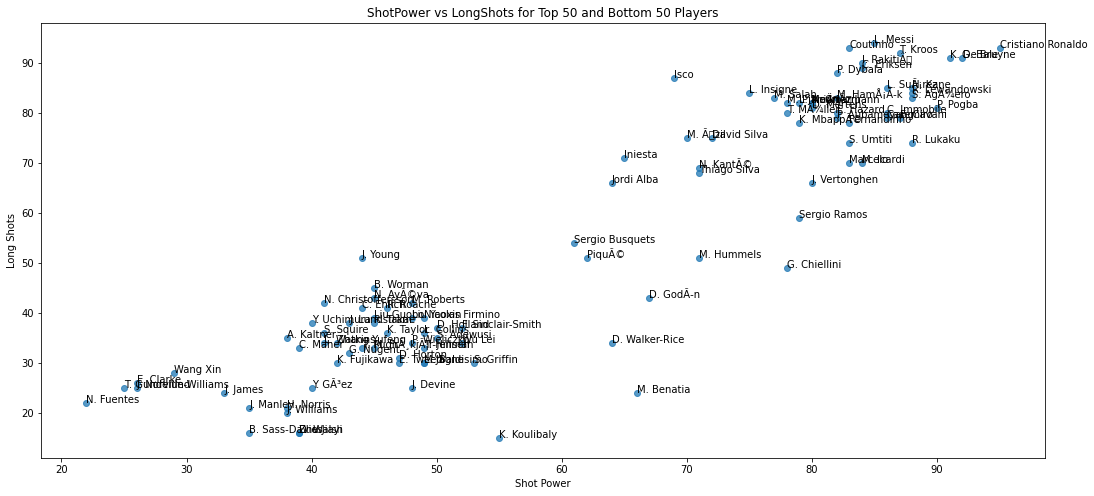

In [10]:
plt.figure()
sns.distplot(fb_data['Age'], bins=len(set(fb_data['Age'])), color='r')
plt.xlabel("Age")
plt.title("Distribution Plot of Age of Players")

top_clubs = fb_data.groupby('Club').agg({'Overall': np.mean}).sort_values('Overall', ascending=False).nlargest(10, columns='Overall').index.values
data_sns = fb_data.loc[fb_data['Club'].isin(top_clubs) & fb_data['Wage']]
data_sns['Wage'] = data_sns['Wage'].str.extract(r'([0-9.]+)').astype('float')
plt.figure()
sns.boxplot(x = 'Club', y = 'Wage', data = data_sns, palette = 'inferno')
plt.xticks(rotation=40)
plt.title("Wage Distribution for Top 10 Clubs based on Overall score of Players")

positions = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']
skills_of_interest = ['Crossing', 'Finishing', 'LongShots', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Balance', 'ShotPower', 'Positioning', 'Vision', 'Penalties',
       'Jumping', 'Strength', 'HeadingAccuracy', 'Aggression', 'Interceptions', 
       'Marking', 'StandingTackle', 'SlidingTackle']

data_hm = fb_data[skills_of_interest + positions]
for col in positions:
  data_hm[col] = data_hm[col].astype('str').str.extract(r'(^\d+)').astype('float')
data_hm = data_hm.corr()
data_hm = data_hm[positions].head(len(skills_of_interest))
# print(data_hm)

plt.figure(figsize=(len(skills_of_interest), len(positions)))
sns.heatmap(data_hm)

data_corr = fb_data.sort_values(['Overall'], ascending = [0]).head(50)[['Name', 'ShotPower', 'LongShots']]
data_corr = data_corr.append(fb_data.sort_values(['Overall'], ascending = [1]).head(50)[['Name', 'ShotPower', 'LongShots']])

plt.figure(figsize=(18, 8))
plt.scatter(data_corr['ShotPower'], data_corr['LongShots'], marker='o', alpha=0.75)
plt.xlabel('Shot Power')
plt.ylabel('Long Shots')
plt.title('ShotPower vs LongShots for Top 50 and Bottom 50 Players')
annot_data = np.array(data_corr)
for t in annot_data:
  plt.annotate(t[0], (t[1], t[2]))



As observed above the players like Messi and Cristiano Rolando Fall together towards one side of the graph coming closer and forming a group.

# Q2.1) Implement k-means clustering algorithm from scratch

In [ ]:
#KNN

df_clusterData = pd.DataFrame(data_scaled)

def calcDistance(centroids, X):
  distances = [sum((centroid - X)**2) for centroid in centroids]
  return np.argmin(distances)

def assignClusters(centroids):
  clusters = df_clusterData.apply(lambda row: calcDistance(centroids, row), axis=1)
  return clusters

def calcCentroids(clusters):
    new_centroids = []
    tmp_df = pd.concat([df_clusterData, pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    for c in set(tmp_df['cluster']):
        current_cluster = tmp_df[tmp_df['cluster']==c][tmp_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

def kmeans(k, num_iter):
  centroids = [df_clusterData.iloc[i] for i in range(k)]
  clusters = assignClusters(centroids)
  for i in range(num_iter):
    centroids = calcCentroids(clusters)
    clusters = assignClusters(centroids)
  return centroids, clusters


# Q2.2) Choose k = 3, 5, 7.  Use only numerical attributes to cluster.

In [ ]:
cluster_res = []
centroids_res = []

for k in [3, 5, 7]:
  final_centroids, final_clusters = kmeans(k, 15)
  cluster_res.append(final_clusters)
  centroids_res.append(final_centroids)
  


# Q2.3) Use elbow method and Silhouette Score to get optimal number of clusters

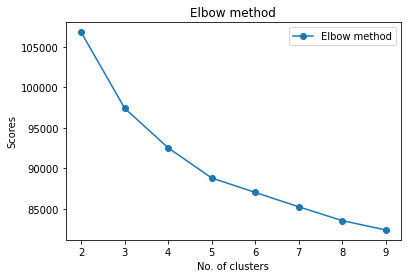

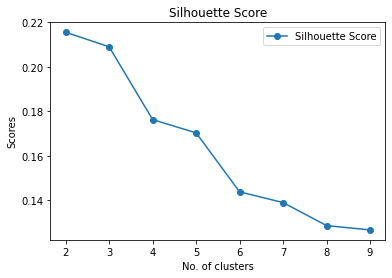

In [ ]:
cluster_wss = []
cluster_sil = []
cluster_k = range(2,10)
# cluster_k = [3, 5, 7]

dummy_cluster_res = []

def calc_wss(clusters, centroids):
    sum_squares = []
    tmp_df = pd.concat([df_clusterData, pd.DataFrame(clusters, columns=['cluster'])], axis=1)
    for c in set(tmp_df['cluster']):
        current_cluster = tmp_df[tmp_df['cluster']==c][tmp_df.columns[:-1]]
        sum_squares.append(np.sum(euclidean_distances(current_cluster, [centroids[c]])))
    return np.sum(sum_squares)

def cal_silhouette_score(clusters):
  return silhouette_score(df_clusterData, clusters, metric = 'euclidean')

for i, k in enumerate(cluster_k):
  kmeans = KMeans(n_clusters = k, max_iter=15).fit(data_scaled)
  dummy_cluster_res.append(kmeans.labels_)
  cluster_wss.append(calc_wss(kmeans.labels_, kmeans.cluster_centers_))
  cluster_sil.append(cal_silhouette_score(kmeans.labels_))
  # final_centroids, final_clusters = kmeans(k, 15)
  # cluster_res.append(final_clusters)
  # centroids_res.append(final_centroids)
  # cluster_wss.append(calc_wss(cluster_res[i], centroids_res[i]))
  # cluster_sil.append(cal_silhouette_score(cluster_res[i]))

plt.figure()
plt.plot(cluster_k, cluster_wss, '-o', label="Elbow method")
plt.xlabel("No. of clusters")
plt.ylabel("Scores")
plt.title("Elbow method")
plt.legend()

plt.figure()
plt.plot(cluster_k, cluster_sil, '-o', label="Silhouette Score")
plt.xlabel("No. of clusters")
plt.ylabel("Scores")
plt.title("Silhouette Score")
plt.legend()

# Q2.4) Analyse the results got in every case and try to mark each cluster.



Components Variance Ratio: 
[0.40391742 0.21631163]
Features of most importance in both components: 
[['RCM', 'RAM', 'LAM', 'RW', 'CAM'], ['Aggression', 'Marking', 'LB', 'CB', 'LCB']]
Features of least importance in both components: 
[['Stamina', 'StandingTackle', 'Marking', 'GKPositioning', 'GKKicking'], ['GKHandling', 'RB', 'GKDiving', 'GKPositioning', 'SlidingTackle']]


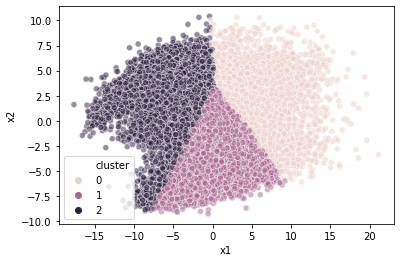

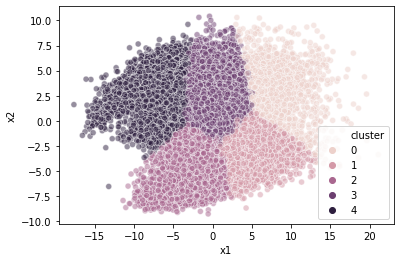

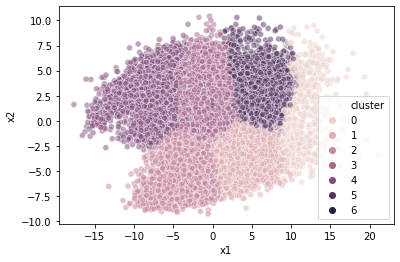

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['x1','x2']

for ind, k in enumerate([3, 5, 7]):
  df_pca['cluster'] = cluster_res[ind]
  plt.figure()
  sns.scatterplot(data=df_pca,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5)

n_pcs= pca.components_.shape[0]
print("Components Variance Ratio: ")
print(pca.explained_variance_ratio_)
ind = np.argsort(abs(pca.components_), axis=1)
print("Features of most importance in both components: ")
print([[cols_of_importance[i] for i in tmpInd[-5:]] for tmpInd in ind])
print("Features of least importance in both components: ")
print([[cols_of_importance[i] for i in tmpInd[:5]] for tmpInd in ind])



# Q3.1) Cluster the data using any Agglomerative(bottom-up strategy) method of your choice.

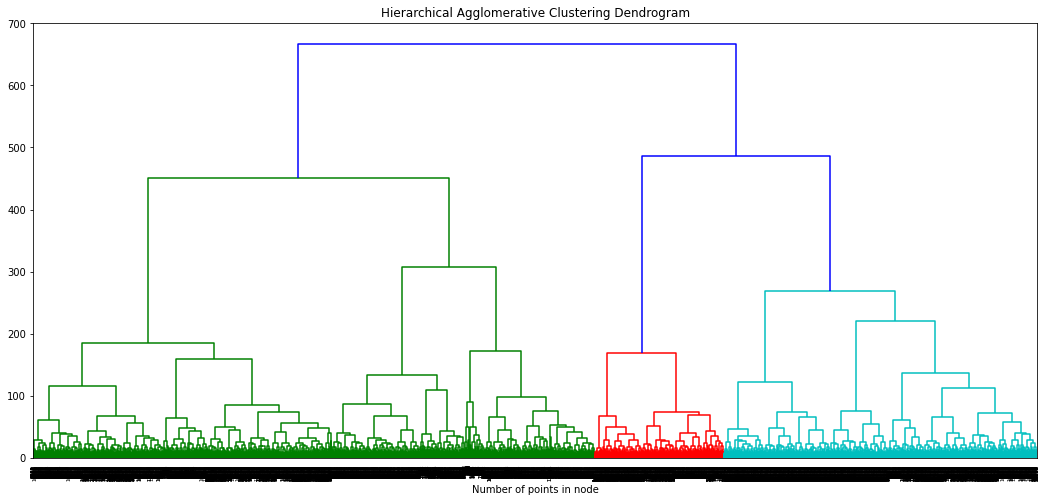

In [ ]:
# Heirachial clustering
# import sys
# sys.setrecursionlimit(100000000)
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram

x = data_scaled
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    return linkage_matrix

    # Plot the corresponding dendrogram
    

# clustering = AgglomerativeClustering(n_clusters = 10).fit(x) 

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)


import plotly.figure_factory as ff

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(x)
plt.figure(figsize=(18, 8))
linkage_matrix = plot_dendrogram(model)
dendrogram(linkage_matrix)
plt.title('Hierarchical Agglomerative Clustering Dendrogram')
plt.xlabel("Number of points in node")
plt.show()


#Q3.2) Cluster the data using any divisive hierarchical clustering method (top-down strategy).

In [ ]:
class DivisiveClustering:
	'''
	Class which implements the DIANA (Divisive Analysis) algorithm and provides an interface for using the implementation.
	'''
	def __init__(self):
		'''
		Initializer for the DivisiveClustering class.
		This function initializes some important class variables.
		'''
		self.clusters={}
		self.dist_matrix=None
		self.mapping=None
		self.no_clusters=0
		self.linkage_matrix=None
		self.n=None
		self.hierarchical_clusters={}
		self.last_index=None

	def initialize(self):
		'''
		Initializer for the DivisiveClustering class.
		Parameters
		----------
		path : string
		    path to file containinng transactions.
		
		Returns
		----------
		transactions : list
			list containing all transactions. Each transaction is a list of
			items present in that transaction.
		items : list
			list containing all the unique items.
		'''
		self.n=len(self.mapping)
		self.last_index=2*self.n-2
		self.i=0
		self.clusters[self.last_index]=list(self.mapping.keys())
		self.linkage_matrix=np.zeros([self.n-1, 4])

	def splinter(self):
		'''
		This function finds the cluster with the largest diameter and finds the splinter element.
		Returns
		----------
		splinter_element : int
			the splinter element. This element will be removed from the cluster that is being split.
		max_diameter_cluster : int
			index of the cluster with the largest diameter. This is the cluster which will be split.
		'''
		cluster_diameters={k:(len(v)<1)*(-1)+(len(v)>1)*np.max(self.dist_matrix[np.ix_(v,v)]) for k,v in self.clusters.items()}
		max_diameter_cluster=max(cluster_diameters, key=cluster_diameters.get)
		avg_within_cluster_distances={pt:(np.sum(self.dist_matrix[np.ix_(self.clusters[max_diameter_cluster], [pt])])/(len(self.clusters[max_diameter_cluster])-1)) for pt in self.clusters[max_diameter_cluster]}
		splinter_element=max(avg_within_cluster_distances, key=avg_within_cluster_distances.get)
		self.no_clusters+=1
		return splinter_element, max_diameter_cluster

	def reassign(self, splinter_element, orig_cluster_key):
		'''
		Function which reassigns points between the original cluster and the splinter cluster.
		Parameters
		----------
		splinter_element : int
		    the splinter element.
		orig_cluster_key : int
		    the ID of the element to be split.
		'''
		# Create temp clusters
		temp_new_cluster=[splinter_element]
		self.clusters[orig_cluster_key].remove(splinter_element)
		temp_orig_cluster=self.clusters[orig_cluster_key]

		# Remove orig cluster from cluster dict
		del self.clusters[orig_cluster_key]

		# Calculate distances
		within_cluster_dist={pt:np.mean(self.dist_matrix[np.ix_(temp_orig_cluster,[pt])]) for pt in temp_orig_cluster }
		dist_to_splinter={pt:self.dist_matrix[pt, splinter_element]  for pt in temp_orig_cluster}
		dist_diff={pt:(within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in temp_orig_cluster} # if +ve, move to splinter
		
		# Reassign points
		for pt in temp_orig_cluster:
			if dist_diff[pt]>0 and len(temp_orig_cluster)>1:
				temp_new_cluster.append(pt)
				temp_orig_cluster.remove(pt)
		
		dist_bw_clusters=np.max(self.dist_matrix[np.ix_(temp_orig_cluster, temp_new_cluster)])
		
		# Add temp clusters to cluster dict
		if len(temp_orig_cluster)==1:
			self.clusters[temp_orig_cluster[0]]=temp_orig_cluster
			orig_cluster_key=temp_orig_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_orig_cluster
			orig_cluster_key=self.last_index

		if len(temp_new_cluster)==1:
			self.clusters[temp_new_cluster[0]]=temp_new_cluster
			new_cluster_key=temp_new_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_new_cluster
			new_cluster_key=self.last_index

		# Append to hierarchical clusters
		self.hierarchical_clusters['iter_'+str(self.no_clusters)]=copy.deepcopy(self.clusters)

		# Make the linkage function
		self.make_linkage_function(new_cluster_key, orig_cluster_key, dist_bw_clusters, len(temp_new_cluster)+len(temp_orig_cluster))

	def make_linkage_function(self, cluster_1, cluster_2, dist, len_cluster_2):
		'''
		Function to create the linakge matrix 'Z' for the dendrogram.
		Parameters
		----------
		cluster_1 : int
		    the ID of the first cluster.
		cluster_2 : string
		    the ID of the first cluster.
		dist : string
		    distance between the newly formed clusters.
		len_cluster_2 : string
		    number of elements in the original cluster which was later split.
		'''
		self.linkage_matrix[self.n-self.no_clusters-1, 0]=cluster_2
		self.linkage_matrix[self.n-self.no_clusters-1, 1]=cluster_1
		self.linkage_matrix[self.n-self.no_clusters-1, 2]=dist
		self.linkage_matrix[self.n-self.no_clusters-1, 3]=len_cluster_2

	def termination(self):
		'''
		Function to check whether clustering has termianted.
		Clustering has terminated when there's only one element in all of the clusters.
		Returns
		----------
		terminated : int (0 or 1)
			function returns 1 on termination. 0 otherwise.
		'''
		for k, v in self.clusters.items():
			if len(v)>1:
				return 0
		return 1

	def fit(self, dist_matrix, mapping):
		'''
		Function that fits the data on the HierarchicalCLustering model.
		Parameters
		----------
		dist_matrix : numpy ndarray
		    the distance matrix.
		mapping : dict
		    mapping of the cluster ids to original names from dataset.
		'''
		self.dist_matrix=dist_matrix
		self.mapping=mapping
		self.initialize()
		while not self.termination():
			splinter_element, orig_cluster_key=self.splinter()
			self.reassign(splinter_element, orig_cluster_key)
		print('Clustering done!')

	def create_dendrogram(self):
		'''
		Function to create the dendrogram using the linakge matrix and save it to file.
		'''
		fig=plt.figure(figsize=(18, 8))
		plt.title("Dendrogram - Divisive Clustering")
		# labels=['temp']*len(self.mapping)
		# for idx,label in self.mapping.items():
			# labels[idx]=label
		# labels=np.array(labels)
		dendrogram(self.linkage_matrix, orientation='top')
		# fig.savefig('dendrogram_divisive.png')
		plt.show()

Clustering done!


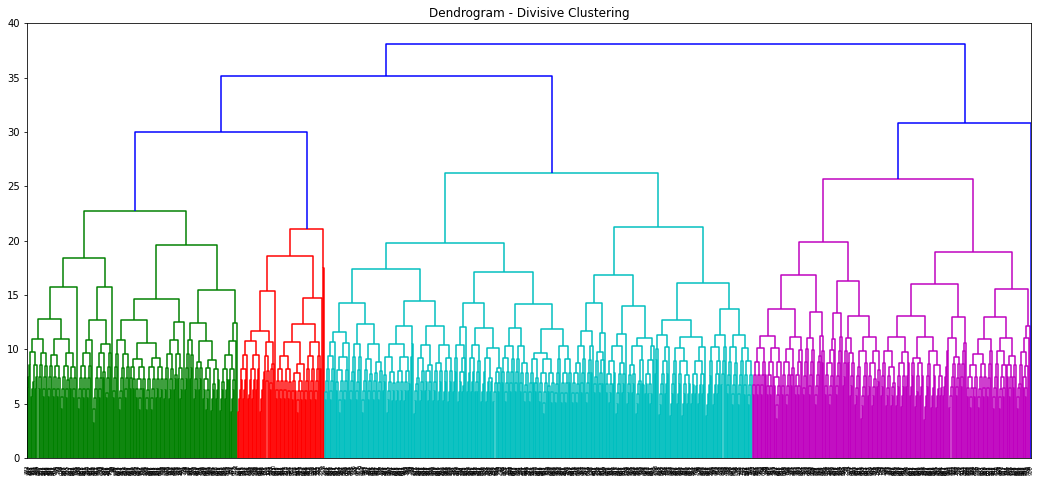

In [ ]:
# data, mapping=read_data()
# dist_matrix=load_dist_matrix(data, mapping)

X = data_scaled[:1000]
dist_matrix = euclidean_distances(X, X)
mapping={ind:k for ind, k in enumerate(X)}
model=DivisiveClustering()
model.fit(dist_matrix, mapping)
model.create_dendrogram()

#Q3.3) Plot a dendrogram for both. Compare the clusters formed by both and analyse the clusters formed.

Clustering done!


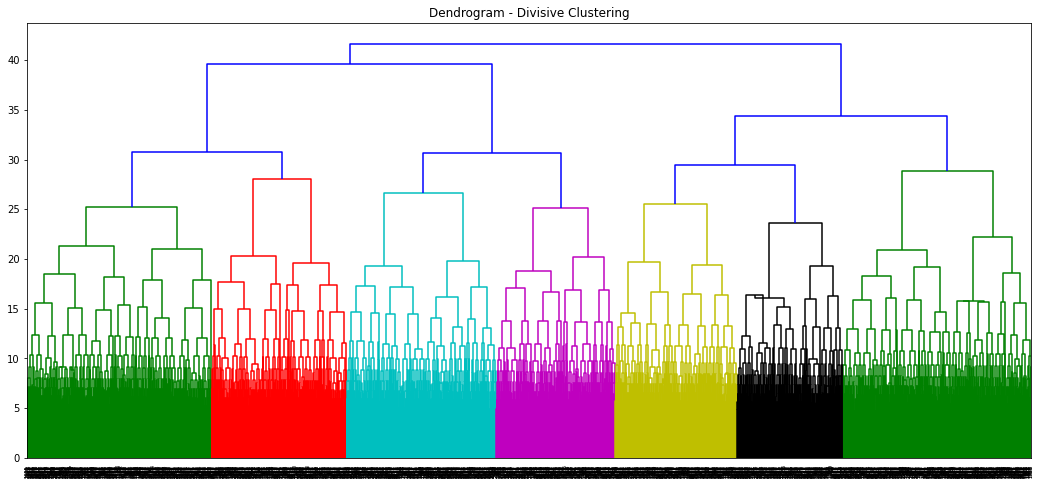

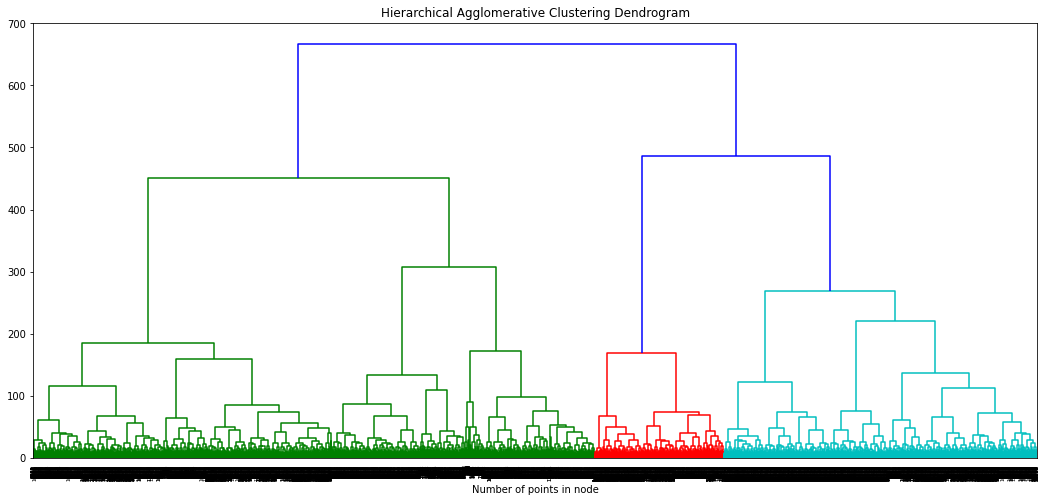

In [ ]:
# No of clusters = k
# No of samples from each cluster = n
# Total no. of sample = n*k
# data_dendrogram is the final dataset that will be used for clustering

k = 3
n = 1000

scaled_df = pd.DataFrame(data_scaled)
kmeans = KMeans(n_clusters = k, max_iter=15).fit(data_scaled)
cluster_map = pd.DataFrame()
cluster_map['index'] = scaled_df.index.values
cluster_map['cluster'] = kmeans.labels_

data_dendrogram = np.empty((0, data_scaled.shape[1]), float)

for i in range(k):
  data_dendrogram = np.append(data_dendrogram, scaled_df.iloc[cluster_map[cluster_map.cluster == i].index.values[:n]], axis=0)

dist_matrix = euclidean_distances(data_dendrogram, data_dendrogram)
mapping={ind:k for ind, k in enumerate(data_dendrogram)}
model=DivisiveClustering()
model.fit(dist_matrix, mapping)
model.create_dendrogram()



model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(x)
plt.figure(figsize=(18, 8))
linkage_matrix = plot_dendrogram(model)
dendrogram(linkage_matrix)
plt.title('Hierarchical Agglomerative Clustering Dendrogram')
plt.xlabel("Number of points in node")
plt.show()


#Q4.1) Use DBSCAN to cluster the data.

#Q4.2) DBSCAN algorithm requires 2 parameters - epsilon and minPts. Show all experiments you did to arrive at the final eps and minPts.

In [ ]:


neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

#plt.plot(distances)
x_axis = np.linspace(0,distances.shape[0]-1,num = distances.shape[0])

fig = go.Figure(data=go.Scatter(x=x_axis, y=distances, mode='lines+markers'))
fig.update_layout(
    title="Elbow curve to find density of the data points",
    xaxis_title="",
    yaxis_title="Epsi values"
    )
fig.show()

In [ ]:
eps = [5.8,6,6.2,6.4,6.6,6.8,7,7.2,7.4,7.6]
for i in eps:
  dbscan = DBSCAN(eps=i,min_samples=5).fit(data_scaled)
  labels = dbscan.labels_
  sil_score = silhouette_score(data_scaled,labels)
  print("for value of epsi ",i)
  print("Silhouette score ", sil_score)

# After trial with several versions of eps and min points, two cluster types were observed when epsi value is taken around 4 and around the elbow point 7

for value of epsi  5.8
Silhouette score  0.23176644945117514
for value of epsi  6
Silhouette score  0.25059024709997485
for value of epsi  6.2
Silhouette score  0.31498019490915935
for value of epsi  6.4
Silhouette score  0.3443393077201136
for value of epsi  6.6
Silhouette score  0.3672452933215188


In [ ]:
min_samp = np.linspace(1,10,num=10)
for i in min_samp:
  dbsc1 = DBSCAN(eps=6,min_samples=i).fit(data_scaled)
  labels1 = set([label for label in dbsc.labels_ if label >= 0])
  print("Min samples ",i)
  print("Number of clusters ", len(set(labels)))#select ideal min based on number of clusters as similar to kmeans algo (5)

#Q4.3) Analyse the clusters formed

Silhouette Coefficient: 0.049


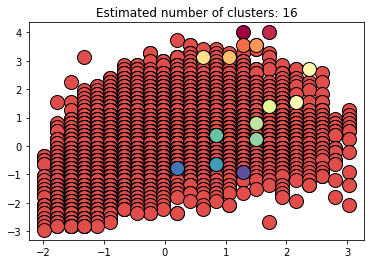

In [22]:
# final dbscan based on optimal values

import matplotlib.pyplot as plt


min_opt =1  #one which gives 5 clusters
dbsc = DBSCAN(eps=7.6,min_samples=min_opt).fit(data_scaled)
labels = dbsc.labels_
import matplotlib.pyplot as plt
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
# Black removed and is used for noise instead.
X = data_scaled
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Silhouette Coefficient: 0.045


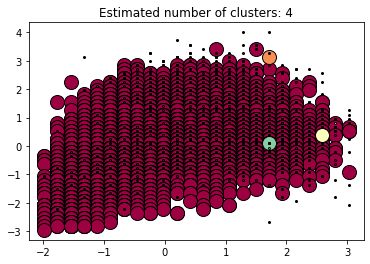

In [18]:
from sklearn import metrics

min_opt =3  #one which gives 5 clusters
dbsc = DBSCAN(eps=5.6,min_samples=min_opt).fit(data_scaled)
labels = dbsc.labels_
import matplotlib.pyplot as plt
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
# Black removed and is used for noise instead.
X = data_scaled
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Silhouette Coefficient: 0.240


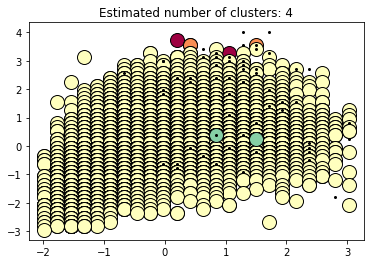

In [27]:
from sklearn import metrics

min_opt =2  #one which gives 5 clusters
dbsc = DBSCAN(eps=6.5,min_samples=min_opt).fit(data_scaled)
labels = dbsc.labels_
import matplotlib.pyplot as plt
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
# Black removed and is used for noise instead.
X = data_scaled
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()